In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import sqlite3

In [217]:
betting_columns = [
    'B365H', 'B365D', 'B365A',
    'BWH',  'BWD',  'BWA',
    'IWH',  'IWD',  'IWA',
    'LBH',  'LBD',  'LBA',
    'WHH',  'WHD',  'WHA',
    'VCH',  'VCD',  'VCA'
]
match_columns = ['match_api_id', 'season', 'stage', 'date', 
                 'home_team_api_id', 'away_team_api_id', 
                 'home_team_goal', 'away_team_goal', 
                 'league_id'] + betting_columns
team_columns = ['team_api_id', 'team_long_name', 'team_short_name']
league_columns = ['id', 'name']

In [218]:
conn = sqlite3.connect('database.sqlite')
match_df = pd.read_sql("SELECT * FROM Match", conn)[match_columns]
team_df = pd.read_sql("SELECT * FROM Team", conn)[team_columns]
league_df = pd.read_sql("SELECT * FROM League", conn)[league_columns]
conn.close()

In [219]:
# Merge team names (for home and away teams) into match_df
match_df = match_df.merge(team_df, left_on='home_team_api_id', right_on='team_api_id', how='left') \
                   .rename(columns={'team_long_name': 'home_team_long_name',
                                    'team_short_name': 'home_team_short_name'}) \
                   .drop('team_api_id', axis=1)

match_df = match_df.merge(team_df, left_on='away_team_api_id', right_on='team_api_id', how='left') \
                   .rename(columns={'team_long_name': 'away_team_long_name',
                                    'team_short_name': 'away_team_short_name'}) \
                   .drop('team_api_id', axis=1)

# Merge league names
match_df = match_df.merge(league_df, left_on='league_id', right_on='id', how='left') \
                   .rename(columns={'name': 'league_name'}) \
                   .drop('id', axis=1)

# Convert date column to datetime and create additional features
match_df['date'] = pd.to_datetime(match_df['date'])
match_df['year'] = match_df['date'].dt.year
match_df['goal_diff'] = match_df['home_team_goal'] - match_df['away_team_goal']

In [220]:
match_df['match_result'] = match_df.apply(
    lambda row: 'Home Win' if row['home_team_goal'] > row['away_team_goal']
                else ('Away Win' if row['home_team_goal'] < row['away_team_goal']
                      else 'Draw'),
    axis=1
)

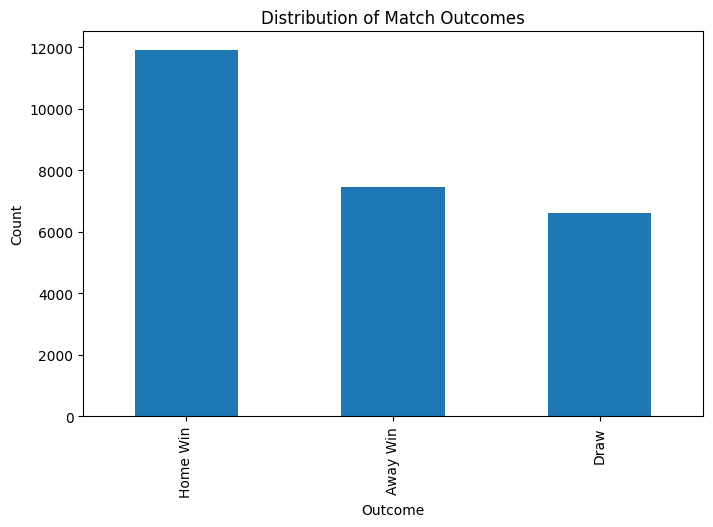

In [221]:
plt.figure(figsize=(8, 5))
match_df['match_result'].value_counts().plot(kind='bar')
plt.title('Distribution of Match Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

In [222]:
team1 = "Real Madrid CF"  # example user input
team2 = "FC Barcelona"            # example user input

# Filter to include only rows where either team is involved:
match_df_model = match_df[(match_df['home_team_long_name'].isin([team1, team2])) |
                             (match_df['away_team_long_name'].isin([team1, team2]))].copy()

# Encode the target variable
le = LabelEncoder()
match_df_model['result_encoded'] = le.fit_transform(match_df_model['match_result'])

feature_columns = ['year', 'stage'] + betting_columns + ['result_encoded'] + ['match_result']
match_df_model = match_df_model[feature_columns]
match_df_model.dropna(inplace=True)

In [223]:
feature_columns = ['year', 'stage'] + betting_columns
X = match_df_model[feature_columns]
y = match_df_model['result_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a logistic regression model
model = LogisticRegression(max_iter=10000, class_weight='balanced')
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Model Accuracy: 0.6460674157303371
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.65      0.67        65
           1       0.10      0.17      0.12        23
           2       0.90      0.77      0.83        90

    accuracy                           0.65       178
   macro avg       0.56      0.53      0.54       178
weighted avg       0.72      0.65      0.68       178

Confusion Matrix:
[[42 22  1]
 [12  4  7]
 [ 6 15 69]]


In [225]:
X.describe()

,year,stage,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA
count,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000
mean,2012.077703,19.452703,4.873818,6.611436,9.574949,4.650828,6.368429,8.731824,4.348818,5.571791,7.787568,4.529730,6.242601,8.594882,4.754932,5.998294,9.537416,5.232407,7.129105,11.127375
std,2.338679,10.998437,4.726877,2.840210,9.954416,4.396765,2.561927,9.145877,3.890194,1.804114,7.380147,4.259841,2.652060,9.040314,4.572144,2.434813,10.353658,5.490227,3.541692,12.781089
min,2008.000000,1.000000,1.040000,3.200000,1.080000,1.030000,3.100000,1.100000,1.050000,3.000000,1.100000,1.040000,3.200000,1.100000,1.020000,2.900000,1.080000,1.030000,3.200000,1.080000
25%,2010.000000,10.000000,1.140000,4.500000,1.360000,1.150000,4.400000,1.395000,1.150000,4.000000,1.400000,1.140000,4.330000,1.360000,1.147500,4.200000,1.360000,1.150000,4.600000,1.400000
50%,2012.000000,19.500000,2.050000,6.000000,3.450000,2.025000,5.750000,3.250000,1.950000,5.200000,3.400000,2.000000,5.500000,3.350000,2.075000,5.500000,3.300000,2.000000,6.000000,3.450000
75%,2014.000000,29.000000,8.000000,8.000000,17.000000,7.750000,7.500000,14.000000,7.000000,6.550000,14.000000,7.500000,7.500000,13.000000,8.000000,7.000000,15.000000,8.000000,8.500000,18.000000
max,2016.000000,38.000000,26.000000,17.000000,41.000000,34.000000,19.500000,51.000000,20.000000,11.000000,25.000000,26.000000,19.000000,51.000000,26.000000,17.000000,51.000000,36.000000,26.000000,67.000000


Feature Importance:
